# Analyzing NYC High School Data

The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets. The datasets available to us for this project are:

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

First, let's start by reading in all the datasets, doing some clean up and creating a `combined` dataframe containing data from all sets.

## Read in the data

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import sys

from mpl_toolkits.basemap import Basemap
import folium
from folium import plugins
import branca.colormap as cm

plt.style.use('fivethirtyeight')


%matplotlib inline

In [100]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    file =  pd.read_csv('schools/{0}'.format(f))
    key = f.replace('.csv', '')
    data[key] = file
    
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding="windows-1252")
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding="windows-1252")

#Let's also print the first five rows of the datasets in the data dictionary:

for key in data.keys():
    print(data[key].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

In [101]:
#Now, let's merge the all_survey and d75_survey dataframes:

survey = pd.concat([all_survey, d75_survey])

#Let's see how many rows and columns the dataset has as well as the first five rows:
print(survey.shape)

survey.head()

(1702, 2773)


,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.
- The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion will make the column name consistent with the other data sets.

First, we'll need to filter the columns to remove the ones we don't need. Luckily, there's a data dictionary at the original data download [location](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8). The dictionary tells us what each column represents. Based on our knowledge of the problem and the analysis we're trying to do, we can use the data dictionary to determine which columns to use.

In [102]:
cols_to_keep = ["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

survey = survey[cols_to_keep]

survey['DBN'] = survey['dbn']

#Let's get the updated number of rows and columns:
survey.shape

(1702, 24)

In [103]:
#Let's add the survey dataframe to the data dictionary:

data['survey'] = survey

## Create `DBN` columns

When we explored all of the datasets, we noticed that some of them, like `class_size` and `hs_directory`, don't have a DBN column. `hs_directory` does have a `dbn` column, though, so we can just rename it.

In [104]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

data['hs_directory']['DBN'].head()

0    17K548
1    09X543
2    09X327
3    02M280
4    28Q680
Name: DBN, dtype: object

The DBN in the `sat_results` data is just a combination of the `CSD` and `SCHOOL CODE` columns in the `class_size` data. The main difference is that the `DBN` is padded, so that the `CSD` portion of it always consists of two digits. That means we'll need to add a leading 0 to the `CSD` if the `CSD` is less than two digits long.

In [105]:
def padding(x):
    x_str = str(x)
    if len(x_str) < 2:
        return x_str.zfill(2)
    else:
        return x_str
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(padding)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

In [106]:
data['class_size']['DBN'].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

## Combine the SAT scores

The `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the `sat_results` dataset contain scores on the different components of the SAT test. We would like to combine them all in one column. Before we can do that, we need to convert them to numeric values as currently they are stored as strings.

In [107]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for col in cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors='coerce')
    
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


## Parsing Geographic Coordinates for Schools

Next, we'll want to parse the latitude and longitude coordinates for each school. This will enable us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` data set. Let's extract them and create two new columns that will store them.

In [108]:
def latitude(x):
    coords = re.findall("\(.+\)", x)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(latitude)

In [109]:
def longtitude(x):
    coords = re.findall("\(.+\)", x)
    lon = coords[0].split(',')[1].replace(')', '')
    return lon

data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(longtitude)

In [110]:
#Since the data is stored in strings, we need to convert it to numeric:

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414,-73.916162
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280,40.710679,-74.000807
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680,40.718810,-73.806500


## Filtering the data

We are only interested in data for highschools, i.e. grades 9 through 12. The `class_size` dataset contains data for lower grades than that. Let's filter them out.

Each school can have multiple program types. Because `GEN ED` is the largest category by far, let's only select rows where `PROGRAM TYPE` is `GEN ED`.

In [111]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']

class_size['GRADE '].unique()

array(['09-12'], dtype=object)

In [112]:
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

class_size['PROGRAM TYPE'].unique()

array(['GEN ED'], dtype=object)

In [113]:
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


## Computing Average Class Sizes

Once we are done cleaning up the data, we will combine the datasets into one. We will use the `DBN` column to combine them on. However, currently, the `DBN` in the `class_size` dataset isn't completely unique. This is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns.

In [114]:
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)

data['class_size'] = class_size

data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


Next, let's condense `demographics`. In this case, the only column that prevents a given DBN from being unique is `schoolyear`. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data

In [115]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


Finally, we'll need to condense the `graduation` data set. The `Demographic` and `Cohort` columns are what prevent DBN from being unique in the graduation data. A `Cohort` appears to refer to the year the data represents, and the `Demographic` appears to refer to a specific demographic group. In this case, we want to pick data from the most recent `Cohort` available, which is 2006. We also want data from the full cohort, so we'll only pick rows where `Demographic` is `Total Cohort`.

In [116]:
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


## Converting AP Test Scores

We're almost ready to combine all of the data sets. The only remaining thing to do is convert the [Advanced Placement (AP)](https://en.wikipedia.org/wiki/Advanced_Placement_exams) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a `1` to `5` scale; `3` or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are much more rare in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the `ap_2010` data set to numeric values first.

There are three columns we'll need to convert:

- `AP Test Takers`
- `Total Exams Taken`
- `Number of Exams with scores 3 4 or 5`

In [117]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for c in cols:
    data['ap_2010'][c] = pd.to_numeric(data['ap_2010'][c], errors='coerce')
    print(data['ap_2010'][c].dtype)

float64
float64
float64


## Merging the data

We will finally merge the datasets into one - `combined`.

In [118]:
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


In [119]:
combined.shape

(479, 33)

In [120]:
sets = ['class_size', 'demographics', 'survey', 'hs_directory']

for s in sets:
    combined = combined.merge(data[s], on='DBN', how='inner')
    
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


In [121]:
combined.shape

(363, 160)

We now have many columns with null (`NaN`) values. This is because we chose to do left joins, where some columns may not have had data. The data set also had some missing values to begin with. We will fill in the missing values in each column with the mean of the column.

In [122]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


## Adding a School District Column for Mapping

The school district is just the first two characters of the `DBN` column. Let's extract them and store them in a new column - `school_dist`.

In [123]:
def school_district(x):
    return x[:2]

combined['school_dist'] = combined['DBN'].apply(school_district)

combined['school_dist'].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

Now that we have cleaned and combined our data, we are ready to analyze it.

## Finding correlations

There are several fields in `combined` that originally came from a [survey of parents, teachers, and students](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8). Let's make a bar plot of the correlations between these fields and sat_score.

In [124]:
survey_cols = ['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11','eng_p_11','aca_p_11','saf_t_11', 'com_t_11', 'eng_t_11','aca_t_11','saf_s_11','com_s_11','eng_s_11','aca_s_11','saf_tot_11','com_tot_11','eng_tot_11', 'aca_tot_11']

correlations = combined.corr()
correlations = correlations['sat_score']
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


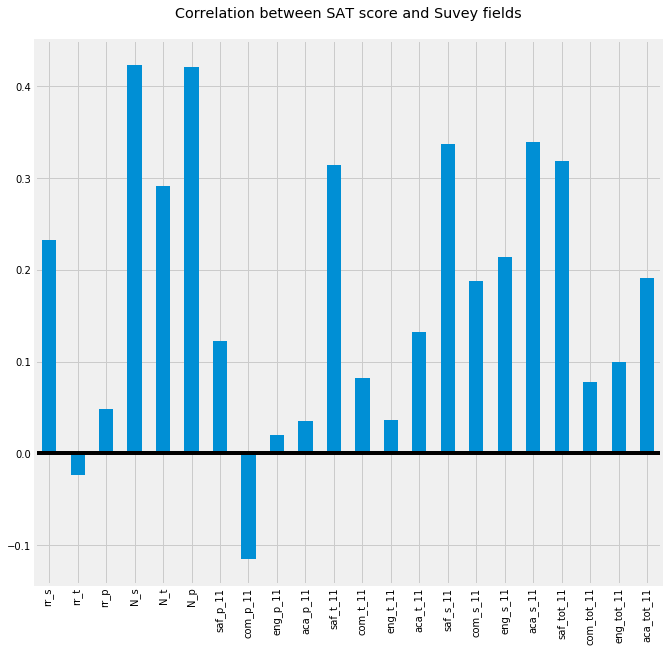

In [125]:
combined.corr()["sat_score"][survey_cols].plot.bar(figsize=(10,10))
plt.title('Correlation between SAT score and Suvey fields', y=1.03)
plt.axhline(color='black')
plt.show()

It looks like there is a strong positive correlation between the sat scores and:

- `N_s` - Number of student respondents
- `N_t` - Number of teacher respondents
- `N_p` - Number of parent respondents
- `saf_s_11` - Safety and Respect score based on student responses
- `saf_t_11` - Safety and Respect score based on teacher responses
- `aca_s_11` - Academic expectations score based on student responses
- `saf_tot_11` - Safety and Respect total score

The correlation between the way students and teachers perceive school safety and the sat results is understandable - it's difficult to teach and study in an unsafe environment. Let's dig into this relationship a bit further.

## Exploring Safety and SAT Scores

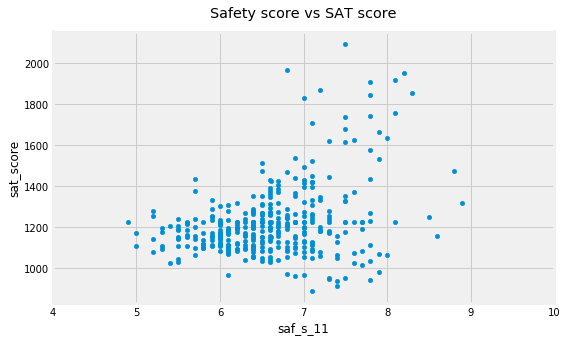

In [126]:
combined.plot.scatter(x='saf_s_11', y='sat_score', figsize=(8, 5))
plt.title('Safety score vs SAT score', y=1.03)
plt.xlim(4, 10)
plt.show()

The scatter plot above visualizes the possitive correlation between the safety score of the schools and the SAT scores.

## Map out safety scores

In [127]:
by_dist = combined.groupby('school_dist').agg(np.mean)
by_dist.reset_index(inplace=True)

In [128]:
m = folium.Map(location=[40.75, -74.125], zoom_start = 10, control_zone=True, tiles='Stamen Terrain', control_scale=True)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>School safety scores by District</b></h3>
             '''

m.get_root().html.add_child(folium.Element(title_html))

size_col = "total_enrollment"
color_col = "saf_s_11"

start_col_val = by_dist[color_col].min()
end_col_val = by_dist[color_col].max()

start_col_hex = "#fee8c8" # used https://colorbrewer2.org/ 
end_col_hex = "#e34a33"

colormap = cm.LinearColormap(colors=[start_col_hex,
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )
colormap.caption = "Safety / Respect Score, students response"

for index, row in by_dist.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_col]),
                  fill_color=colormap(row[color_col]),
                  fill_opacity=0.75,
                  radius=row[size_col],
                  weight=2,
                  tooltip="District "+row["school_dist"]+
                      " <br> Avg. Safety/Respect Score, students response (color): {:.1f}".format(row[color_col])+
                      " <br> Avg. Enrollment per school (size): {:.0f}".format(row[size_col])
                 ).add_to(m)

# add a legend
m.add_child(colormap)

m

## SAT scores by race

There are a few columns that indicate the percentage of each race at a given school:

- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

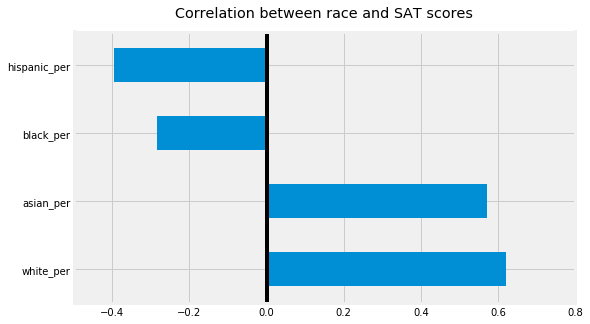

In [129]:
race = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()['sat_score'][race].plot.barh(figsize=(8,5))
plt.title('Correlation between race and SAT scores', y=1.03)
plt.xlim(-0.5,0.8)
plt.axvline(color='black')
plt.show()

It looks like there is a strong possitive correlation between the SAT scores and the high percentage white and asians students.
There is a negative correlation between the SAT scores and the high percentage black and hispanic students.

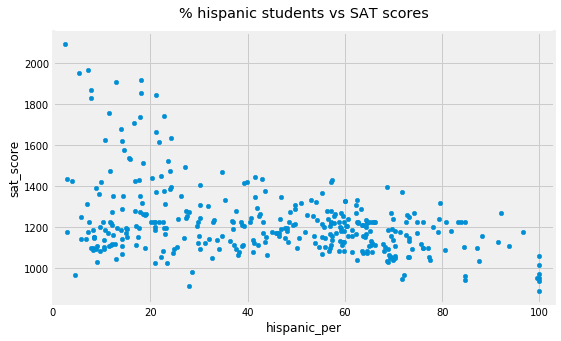

In [130]:
combined.plot.scatter(x='hispanic_per', y='sat_score', figsize=(8,5))
plt.title('% hispanic students vs SAT scores', y=1.03)
plt.xlim(0,103)
plt.show()

It seems that the schools whose students achieve greater SAT scores, have less than 20% hispanic students.

Let's isolate the schools which have over 95% hispanic students.

In [131]:
hispanic_schools = combined[combined['hispanic_per'] > 95]
hispanic_schools['SCHOOL NAME'].unique()

array(['MANHATTAN BRIDGES HIGH SCHOOL',
       'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL',
       'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS',
       'ACADEMY FOR LANGUAGE AND TECHNOLOGY',
       'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE',
       'MULTICULTURAL HIGH SCHOOL',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL'], dtype=object)

 - **Manhattan Bridges High School** is a public school in Manhattan, NY, with a student-teacher ratio of 18 to 1*. The school caters to immigrants recently arrived from Spanish-speaking countries.
 - **Washington Heights Expeditionary Learning School** is a public school in Manhattan, NY, with a student-teacher ratio of 13 to 1. The school's students  are predominantely Spanish speaking Dominican American and/or born in the Dominican Republic.
 - **Gregorio Luperon High School for Science and Mathematics** is a public school in Manhattan, NY, with a student-teacher ratio of 19 to 1. The school serves Spanish-speaking students who are new to this country
 - **Academy for Language and Technology** is a public school in the Bronx, NY, with a student-teacher ratio of 13 to 1. The school offers new immigrants a safe, orderly environment and the chance to learn computer programming and maintenance.
 - **International School for Liberal Arts** is a public school in the Bronx, NY, with a student-teacher ratio of 13 to 1. It is designed to offer Spanish-speaking teens a gentle transition to English.
 - **Pan American International High School at Monroe** is a public school in the Bronx, NY, with a student-teacher ratio of 15 to 1. It offers new immigrants—including many unaccompanied minors—the chance to learn English and complete high school.
 - **Multicultural High School** is a public school located in Brooklyn, NY, with a student-teacher ratio of 10 to 1. It serves Spanish-speaking students who have been in the United States for less than three years.
 - **Pan American International High School** is a public school located in Elmhurst, NY, with a student-teacher ratio of 11 to 1. Students there all speak Spanish and have been in the United States for less than four years. 
 
All in all, all eight schools have a predominantly immigrant students. The fact that English is not the students' first language might have an affect on their preformence on the SAT.
_________
*The national average public school student:teacher ratio is approximately 16:1, Source: [Public School Review](https://www.publicschoolreview.com/average-student-teacher-ratio-stats/national-data)

-------
The above school information was taken from the following websites:

- [Inside Schools](https://insideschools.org/)
- [Niche](https://www.niche.com/?ref=k12)

## Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:

- `male_per`
- `female_per`

We can plot out the correlations between each percentage and `sat_score`.

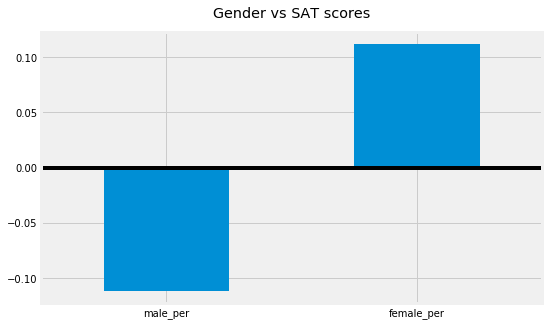

In [132]:
gender = ['male_per', 'female_per']

combined.corr()['sat_score'][gender].plot.bar(figsize=(8,5), rot=360)
plt.axhline(color='black')
plt.title('Gender vs SAT scores', y=1.03)
plt.show()

There is a positive correlation between the high percent female students and SAT scores and a negative correlation between high percent male students and SAT scores.

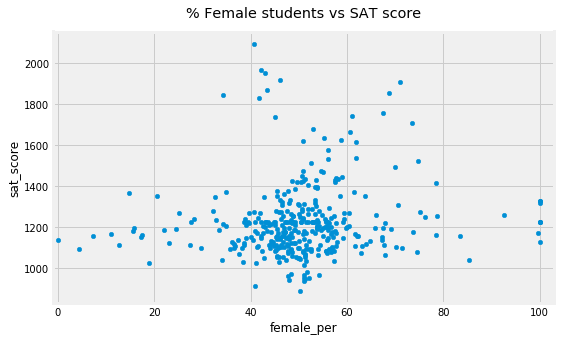

In [133]:
combined.plot.scatter(x='female_per', y='sat_score', figsize=(8, 5))
plt.title('% Female students vs SAT score', y=1.03)
plt.xlim(-1, 103)
plt.show()

It is interesting to see that the scatter plot **does not** confirm the correlation.

Let's isolate the schools with over 60% female students and high SAT scores:

In [134]:
female_high  = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

female_high['SCHOOL NAME'].unique()

array(['BARD HIGH SCHOOL EARLY COLLEGE', 'ELEANOR ROOSEVELT HIGH SCHOOL',
       'BEACON HIGH SCHOOL',
       'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS',
       'TOWNSEND HARRIS HIGH SCHOOL'], dtype=object)

- **Bard High School Early College** is a public school in NY with a student-teacher ratio of 17 to 1. It offers small class sizes, excellent teaching, and the promise of two years of college credit for free.
- **Eleanor Roosevelt High School** is a public school in NY with a student-teacher ratio of 17 to 1. It offers a traditional college-prep curriculum.
- **Beacon High School** is a public school in Manhattan, NY with a student-teacher ratio of 23 to 1. It is a selective college-preparatory school.
- **Fiorello H. Laguardia High School of Music & Art and Performing Arts** is a public school located in New York, NY with a student-teacher ratio of 20 to 1. It was founded as a way to give aspiring actors, dancers, and singers the technical skills they need to become professional performers and the academic skills they need in whatever career they choose. Students receive first-rate training from professional studios and companies, including the Ailey School for dance, Rosie’s Theater Kids for musical theater, the National Chorale for voice and Waterwell for drama.
- **Townsend Harris High School** is a public school in Queens, NY, with a student-teacher ratio of 20 to 1. It combines rigorous academics with a well-rounded high school experience.

All in all, the above schools have an above average students to teacher ratio. All are focused on preparing students for college which might be the reason why the SAT scores of their students are higher.

## Exploring AP Scores vs. SAT Scores

In the U.S., high school students take [Advanced Placement (AP)](https://en.wikipedia.org/wiki/Advanced_Placement_exams) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. We'll look at the percentage of students in each school who took at least one AP exam.

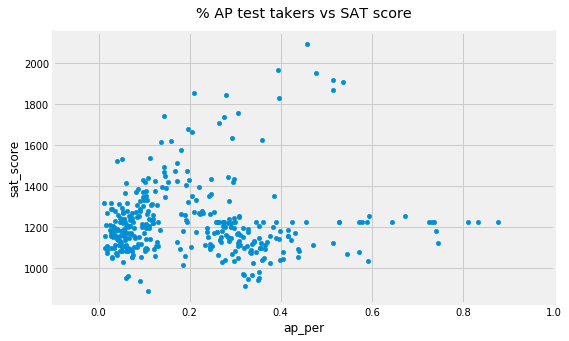

In [135]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

combined.plot.scatter(x='ap_per', y='sat_score', figsize=(8, 5))
plt.xlim(-0.1, 1)
plt.title('% AP test takers vs SAT score', y=1.03)
plt.show()

It seems that the correlation between the percent students who take the AP test and the SAT score isn't that high.

## Class size vs SAT score

Let's see wheter there's a correlation between class size and SAT scores.

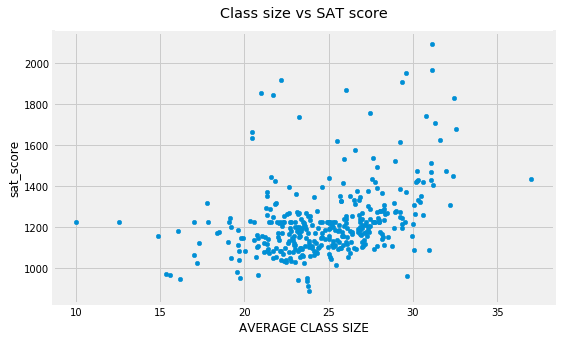

In [136]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score', figsize=(8, 5))
plt.title('Class size vs SAT score', y=1.03)
plt.show()

It seems that there is a slight correlation between the average class size and the SAT score. It is interesting to see that the best SAT scores were achieved in average class sizes of 20-35. It's also interesting to see that lower class size does not necessarily mean better SAT results.

## Neighborhoods with best schools

In [137]:
best = combined[combined['sat_score'] > 1700]
best['boro'].value_counts(normalize=True)

Manhattan        0.461538
Bronx            0.153846
Queens           0.153846
Brooklyn         0.153846
Staten Island    0.076923
Name: boro, dtype: float64

It looks like 46% of the schools whose students achieve best results on th SAT are located in Manhattan.

## School scores based on SAT scores

Based on the [College Board Review](https://reports.collegeboard.org/pdf/2019-total-group-sat-suite-assessments-annual-report.pdf), we will split the schools in three categories based on the average SAT score of their students:

- Below average: SAT score below 1000
- Average: SAT score between 1000 - 1190
- Above average: SAT score between 1190 - 1400
- Overachievers: SAT score over 1400

In [138]:
def sat_scores(x):
    if x <= 1000:
        return "Below average"
    elif 1000 < x <=1190:
        return "Average"
    elif 1190 < x <= 1400:
        return "Above average"
    elif x > 1400:
        return "Overachievers"

In [139]:
combined['school_score'] = combined['sat_score'].apply(sat_scores)

combined['school_score'].value_counts(normalize=True)*100

Average          46.280992
Above average    38.842975
Overachievers    11.570248
Below average     3.305785
Name: school_score, dtype: float64

It looks like only 3% of the schools preform below average at the SAT and about 11.5% exceed in their average scores.

## Parents vs Teachers vs Students

Let's explore how the parents, teachers and students percieve the school environment. We will focus on those columns:

- Safety score - `saf_p_11`, `saf_t_11`, `saf_s_11`
- Communication score - `com_p_11`, `com_t_11`, `com_s_11`
- Engagement score - `eng_p_11`, `eng_t_11`, `eng_s_11`
- Academic expectation score - `aca_p_11`, `aca_t_11`, `aca_s_11`

We will calculate the mean for each category for each group and then plot them to see if there are any major differences in the way each group percieves the school environment.

In [140]:
parents = ['saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11']
teachers = ['saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11']
students = ['saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11']

parents_means = []

for p in parents:
    parents_means.append(combined[p].mean())
    
teachers_means = []

for t in teachers:
    teachers_means.append(combined[t].mean())
    
students_means = []

for s in students:
    students_means.append(combined[s].mean())

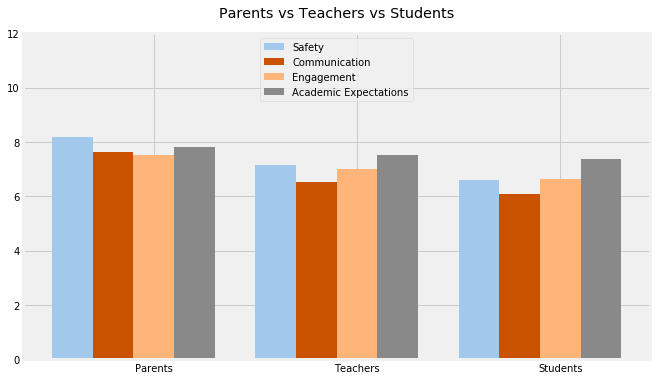

In [141]:
data = np.array([parents_means, teachers_means, students_means])
length = len(data)
width = 0.2
x = np.arange(length)
x_labels = ['Parents', 'Teachers', 'Students']
              
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, data[:,0], width, color=(162/255,200/255,236/255), label='Safety')
ax.bar(x, data[:,1], width, color=(200/255,82/255,0/255), label='Communication')
ax.bar(x + width, data[:,2], width, color=(255/255,181/255,121/255), label='Engagement')
ax.bar(x + (2 * width), data[:,3], width, color=(137/255,137/255,137/255), label='Academic Expectations')
plt.legend(loc='upper center')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
plt.ylim(0,12)
plt.title('Parents vs Teachers vs Students', y=1.03)
plt.show()

We see that on average, parents rate the school environment higher than student and teachers do, whereas Students and Teachers have similar ratings. This might be due to the fact that parents do not have first hand experience of the schools.

## Conclusion

In this project we analyzed data on the SAT scores of students in NYC schools.
We found out that the more the students and teachers percieve the school as safe, the better the SAT scores. We also found out that the schools with majority of students who do not have English as a first language and/or have recently moved to the US tend to score lower results.